In [1]:
from PIL import Image
import tensorflow.keras as keras
import numpy as np
import os
import re
import pandas as pd
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
keras.__version__

'2.6.0'

# params

In [2]:
size = 128
n = 25000
test_size = 0.1
random_state = 0

# Generate model

In [3]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [4]:
base_model = ResNet50(include_top=False, weights='imagenet', classes=2, input_shape = (size,size,3))

Metal device set to: Apple M1


2021-10-29 19:30:53.594405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-29 19:30:53.594552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
model = base_model.layers[:3]
model = models.Sequential(model)
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 134, 134, 3)       0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 64, 64, 64)        9472      
_________________________________________________________________
dense (Dense)                (None, 64, 64, 2)         130       
Total params: 9,602
Trainable params: 9,602
Non-trainable params: 0
_________________________________________________________________


In [6]:
for layes in base_model.layers:
    layes.trainable = False
model = models.Sequential()
model.add(base_model)
model.add(layers.AvgPool2D())
model.add(layers.Flatten())
#model.add(layers.Dropout(rate = 0.2))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(rate = 0.2))
model.add(layers.Dense(2, activation='softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
average_pooling2d (AveragePo (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 16386     
Total params: 23,604,098
Trainable params: 16,386
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
model.compile(optimizer = 'Adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [8]:
model.load_weights('ResNet50')

# Preprocess data

In [9]:
def preprocess_image(path, file_name, size):
    Photo = Image.open(path + file_name)
    Photo = Photo.resize([size,size])
    Im = np.array(Photo)
    Im = Im.reshape(size,size,3)/255
    return(Im)

In [10]:
path = 'dogs-vs-cats/train/'
file_list = os.listdir(path)
# Im = np.array([preprocess_image(path, f_n, size) for f_n in file_list])

In [11]:
# np.save('128x128', Im)
Im = np.load('128x128.npy')
#Im1 = Im

In [12]:
Im.shape

(25000, 128, 128, 3)

In [11]:
# file_list = os.listdir('dogs-vs-cats/train/')
# # index 0
# Photo = Image.open('dogs-vs-cats/train/' + file_list[0])
# Photo = Photo.resize([size,size])
# Im = np.array(Photo)
# Im = Im.reshape(1,size,size,3)/255
# # index i
# for i in file_list[:n]:
#     Photo = Image.open('dogs-vs-cats/train/' + i)
#     Photo = Photo.resize([size,size])
#     Im_temp = np.array(Photo)
#     Im_temp = Im_temp.reshape(1,size,size,3)/255
#     Im = np.concatenate((Im, Im_temp), axis = 0)

In [13]:
x = Im.reshape(n, size, size, 3, 1)
# y = np.array([re.findall('dog|cat', i) for i in file_list[0:n]]).reshape(n)
# y[y == 'dog'] = '1'
# y[y == 'cat'] = '0'
y_str = [re.findall('dog|cat', i) for i in file_list[:n]]
y = [1 if i == ['dog'] else 0 for i in y_str]
y = keras.utils.to_categorical(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
X_train.shape
y_train.shape

(22500, 2)

In [15]:
import gc
del x, y
gc.collect()

8804

# Fit model

In [ ]:
model.fit(X_train, y_train, epochs=1, batch_size=1)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

In [ ]:
model.save_weights('ResNet50')

# Test

In [72]:
def test_dog(Im, size, model):
    plt.imshow(Im)
    Im = Im.resize([size,size])
    Im = np.array(Im)/255
    Im = Im[:,:,:3].reshape(1, size, size, 3)
    print(model.predict(Im))
    is_dog = np.argmax(model.predict(Im),axis=1)
    print('预测结果: 狗' if is_dog==1 else '预测结果: 猫')

def test_dog_top_n(path, size, model, n=30):
    plt.figure()
    fig,ax = plt.subplots(int(n/5+0.5),5)
    fig.set_figheight(3*int(n/5+0.5))
    fig.set_figwidth(15)
    ax=ax.flatten()
    for i in range(n):
        Im = Image.open(path + str(i+1) + '.jpg')
        ax[i].imshow(Im)
        Im = Im.resize([size,size])
        Im = np.array(Im)/255
        Im = Im[:,:,:3].reshape(1, size, size, 3)
        is_dog = np.argmax(model.predict(Im),axis=1)
        ax[i].set_title(str(i+1)+'. dog' if is_dog==1 else str(i+1)+'. cat')
        # print(str(i+1)+' 预测结果: 狗' if is_dog==1 else str(i+1)+' 预测结果: 猫')

[[1.6241059e-06 9.9999833e-01]]
预测结果: 狗


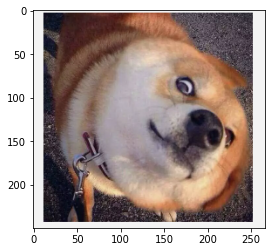

In [73]:
path = '试试看'
Photo = Image.open(path + '/狗头4.png')

np.array(Photo)

# path = 'dogs-vs-cats/test1/'
# Photo = Image.open(path + '13.jpg')

test_dog(Photo, size, model)
# test_dog_top_n(path, size, model, 100)

array([0.64705882, 0.61960784, 0.64705882])

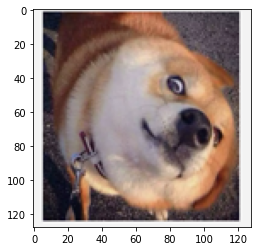

In [94]:
Photo2 = Photo.resize([size,size], Image.BICUBIC)
x = np.array(Photo2)/255
plt.imshow(Photo2)
x[63, 63, :3]
# model.predict(x[:, :, :3].reshape(1,128,128,3))

array([[8.260062e-09, 1.000000e+00]], dtype=float32)

# 终极大预测

In [17]:
n = 100
test_label = pd.read_csv('test.csv')
path = 'dogs-vs-cats/test1/'
for i in range(n):
    Im = Image.open(path + str(i+1) + '.jpg')
    Im = Im.resize([size,size])
    Im = np.array(Im)/255
    Im = Im[:,:,:3].reshape(1, size, size, 3)
    is_dog = np.argmax(model.predict(Im),axis=1)
    is_dog_str = 'dog' if is_dog==1 else 'cat'
    if is_dog_str!=test_label.iloc[i,0]:
        print(str(i+1)+'错了')

15错了
17错了
25错了
29错了
64错了
75错了
81错了
100错了


预测结果: 猫


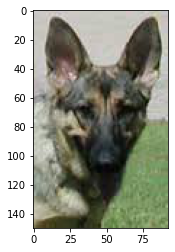

In [121]:
Photo = Image.open(path + '86.jpg')
test_dog(Photo, size, model)